# SARIG data package lithogeochem dataset_Protolith Predictor

This notebook uses the protolith prediction app runnnig locally. First we display the results on a validation dataset of classified data from the SARIG database.
Then run the model on the non igneous or sedimentary labeld dataset and graphically show the results. Finally we run the unlabeld dataset and output the final results. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load and transform SARIG data for processing

In [2]:
df1 = pd.read_csv(r'D:\Python ML\SA-geology-lith-predictions\data\SARIG_major_els_v1.csv')

In [3]:
df1.head()

,SAMPLE_ANALYSIS_NO,Al2O3,CaO,FeO,K2O,MgO,Na2O,P2O5,SiO2,TiO2,ROCK_GROUP,LITHOLOGY_NAME
0,122,14.835600,8.747888,10.219042,1.422171,4.726929,2.312307,0.092083,56.784538,0.859442,Igneous Mafic Extrusive,Tholeiite
1,124,15.301193,9.190985,9.517576,1.417157,4.990859,2.156544,0.071885,56.480914,0.872887,Igneous Mafic Extrusive,Tholeiite
2,126,15.342181,6.126576,10.284280,2.244695,5.354318,4.386422,0.092671,55.293632,0.875225,Igneous Mafic Extrusive,Tholeiite
3,128,16.703718,9.139770,7.940455,1.386724,4.454325,2.185140,0.094549,57.149826,0.945493,Igneous Mafic Extrusive,Tholeiite
4,130,19.428504,3.969264,1.823384,6.737304,1.128107,2.277104,0.020891,63.508227,1.107216,Igneous Mafic Extrusive,Tholeiite


In [4]:
df1['ROCK_GROUP'].value_counts()

Igneous Felsic Intrusive                2256
Metamorphic General                     1936
Igneous Felsic Extrusive                 922
Igneous Mafic Intrusive                  868
Metasediment                             544
                                        ... 
Igneous Ultramafic Extrusive               1
Igneous Feldspathoidal Extrusive           1
Mineralised Rock/Ore                       1
Igneous Mafic Extrusive Effusive           1
Sediment Chemical/Biogenic Evaporite       1
Name: ROCK_GROUP, Length: 64, dtype: int64

Apply labels to data based on rock group field. 0 = igneous, 1 = sedimentary

In [5]:
df1['labels'] = np.where((df1.ROCK_GROUP.str.contains('Igneous')), 0 , (np.where((df1.ROCK_GROUP.str.contains('Sediment')), 1 , np.nan)))


Create 3 datasets. One with lithology labels known (df_classified) and one with non-igneous or sedimentary labels (df_met) including a data df to predict on and a labels df to validate against. Finally create an un_labeled dataset from the remaining un labeled data to generate new lithology predictions on.

In [6]:
df_classified, df_labels  = df1[(df1['ROCK_GROUP'].notnull()) & (df1['labels'].notnull())].drop(['ROCK_GROUP','LITHOLOGY_NAME','labels'],axis=1), df1[(df1['ROCK_GROUP'].notnull()) & (df1['labels'].notnull())][['SAMPLE_ANALYSIS_NO','ROCK_GROUP','LITHOLOGY_NAME', 'labels']]

df_met, df_met_labels = df1[(df1['ROCK_GROUP'].notnull()) & (df1['labels'].isnull())].drop(['ROCK_GROUP','LITHOLOGY_NAME','labels'],axis=1), df1[(df1['ROCK_GROUP'].notnull()) & (df1['labels'].isnull())][['SAMPLE_ANALYSIS_NO','ROCK_GROUP','LITHOLOGY_NAME','labels']] 

df_unlabeled = df1[df1['ROCK_GROUP'].isnull()].drop(['ROCK_GROUP','LITHOLOGY_NAME','labels'],axis=1) 


In [7]:
df_classified.head()

,SAMPLE_ANALYSIS_NO,Al2O3,CaO,FeO,K2O,MgO,Na2O,P2O5,SiO2,TiO2
0,122,14.835600,8.747888,10.219042,1.422171,4.726929,2.312307,0.092083,56.784538,0.859442
1,124,15.301193,9.190985,9.517576,1.417157,4.990859,2.156544,0.071885,56.480914,0.872887
2,126,15.342181,6.126576,10.284280,2.244695,5.354318,4.386422,0.092671,55.293632,0.875225
3,128,16.703718,9.139770,7.940455,1.386724,4.454325,2.185140,0.094549,57.149826,0.945493
4,130,19.428504,3.969264,1.823384,6.737304,1.128107,2.277104,0.020891,63.508227,1.107216


## Output cleaned interim datasets to run the Flask Protolith prediction app on

In [8]:
df_classified.to_csv(r'D:\Python ML\SA-geology-lith-predictions\data\interim\SARIG_validation.csv',index=False)
df_met.to_csv(r'D:\Python ML\SA-geology-lith-predictions\data\interim\SARIG_met.csv',index=False)
df_unlabeled.to_csv(r'D:\Python ML\SA-geology-lith-predictions\data\interim\SARIG_unlabeled.csv',index=False)

In [9]:
print(df_classified.shape)
print(df_labels.shape)

(6809, 10)
(6809, 4)


In [10]:
print(df_met.shape)
print(df_met_labels.shape)

(3613, 10)
(3613, 4)


In [11]:
print(df_unlabeled.shape)

(148954, 10)


## Load the Protolith App SARIG labeled output dataset

In [12]:
SARIG_predicted = pd.read_csv(r'D:\Python ML\SA-geology-lith-predictions\data\interim\SARIG_val_Lithology_predictions.csv')

In [13]:
SARIG_predicted.head()

,SAMPLE_ANALYSIS_NO,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,P2O5,Class,Probability,Lithology
0,122,56.784538,0.859442,14.835600,10.219042,4.726929,8.747888,2.312307,1.422171,0.092083,igneous,0.991582,"Basaltic Andesite, Gabbroic Diorite"
1,124,56.480914,0.872887,15.301193,9.517576,4.990859,9.190985,2.156544,1.417157,0.071885,igneous,0.989938,"Basaltic Andesite, Gabbroic Diorite"
2,126,55.293632,0.875225,15.342181,10.284280,5.354318,6.126576,4.386422,2.244695,0.092671,igneous,0.981254,"Basaltic Trachyandesite, Monzodiorite"
3,128,57.149826,0.945493,16.703718,7.940455,4.454325,9.139770,2.185140,1.386724,0.094549,igneous,0.989514,"Andesite, Diorite"
4,130,63.508227,1.107216,19.428504,1.823384,1.128107,3.969264,2.277104,6.737304,0.020891,igneous,0.936833,"Trachydacite, Quartz-syenite"


Create a prediction df with the predicted and labeled values

In [14]:
SARIG_labeled_predicted = pd.merge(SARIG_predicted, df_labels, how= 'left', on='SAMPLE_ANALYSIS_NO')
SARIG_labeled_predicted['Predicted_label'] = np.where((SARIG_labeled_predicted.Class.str.contains('igneous')), 0, 1) 
SARIG_labeled_predicted.sample(20)

,SAMPLE_ANALYSIS_NO,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,P2O5,Class,Probability,Lithology,ROCK_GROUP,LITHOLOGY_NAME,labels,Predicted_label
2743,127921,64.441326,0.064441,0.953732,0.231939,0.953732,32.349546,0.451089,0.502642,0.051553,sedimentary,0.773781,Limestone,Sediment Chemical/Biogenic Carbonate,Coquina,1.0,1
4520,1430291,48.740886,2.139448,13.374085,16.358734,6.509600,9.744121,2.413216,0.517118,0.202791,igneous,0.995775,"Basalt, Gabbro",Igneous Intermediate Intrusive,Diorite,0.0,0
2617,127234,71.529341,0.244545,15.080260,2.182098,0.825339,1.711813,4.187829,4.126693,0.112083,igneous,0.994220,"Rhyolite, Granite",Igneous Felsic Intrusive,Granite,0.0,0
2879,131554,78.137194,0.128010,11.879311,1.161058,0.081926,0.143371,3.543312,4.905336,0.020482,igneous,0.992624,"Rhyolite, Granite",Igneous Felsic Intrusive,Granite,0.0,0
2178,94863,77.413565,0.419170,10.980213,3.293363,1.216616,1.676680,3.363585,1.472207,0.164601,sedimentary,0.750657,Litharnite,Sediment Siliciclastic Arenite,Sandstone,1.0,1
6643,1703124,51.824795,0.565967,22.527695,6.981331,4.860655,5.071506,0.876694,6.625140,0.666219,igneous,0.779156,"Basaltic Trachyandesite, Monzodiorite",Sediment Siliciclastic Lutite,Shale,1.0,0
3680,286642,52.586477,0.411944,15.867486,8.365267,8.015115,11.798900,2.522523,0.427202,0.005086,igneous,0.995557,"Basaltic Andesite, Gabbroic Diorite",Igneous Mafic Intrusive,Gabbronorite,0.0,0
6446,1690700,79.182124,0.172135,11.431793,1.594441,0.182261,0.172135,1.579592,5.680457,0.005063,igneous,0.977381,"Rhyolite, Granite",Igneous Felsic Extrusive Fragmental,Ignimbrite,0.0,0
211,5074,70.207065,0.554797,14.323855,3.213105,0.655669,1.896398,3.873493,5.063785,0.211832,igneous,0.995901,"Rhyolite, Granite",Igneous Felsic Extrusive,Rhyodacite,0.0,0
127,3984,47.625740,3.447617,16.354083,14.118966,5.458728,8.563793,2.342612,1.602258,0.486202,igneous,0.995824,"Basalt, Gabbro",Igneous Mafic Extrusive,Basalt,0.0,0


## Model stats on unseen SARIG data

In [15]:
SARIG_predict, SARIG_true = SARIG_labeled_predicted['Predicted_label'],SARIG_labeled_predicted['labels']

print(classification_report(SARIG_predict, SARIG_true))
print('\n')
print('confusion matrix')
print(confusion_matrix(SARIG_predict, SARIG_true))
print('\n')
print(f'AUC score = {roc_auc_score(SARIG_predict, SARIG_true)}')

precision    recall  f1-score   support

           0       0.92      0.97      0.95      5559
           1       0.85      0.63      0.73      1250

    accuracy                           0.91      6809
   macro avg       0.89      0.80      0.84      6809
weighted avg       0.91      0.91      0.91      6809



confusion matrix
[[5417  142]
 [ 458  792]]


AUC score = 0.8040279186904119


### Plot by Rock_group with predicted values as either igneous (Predicted_label=0) or sedimentary (Predicted_label=1)


(0, 400)

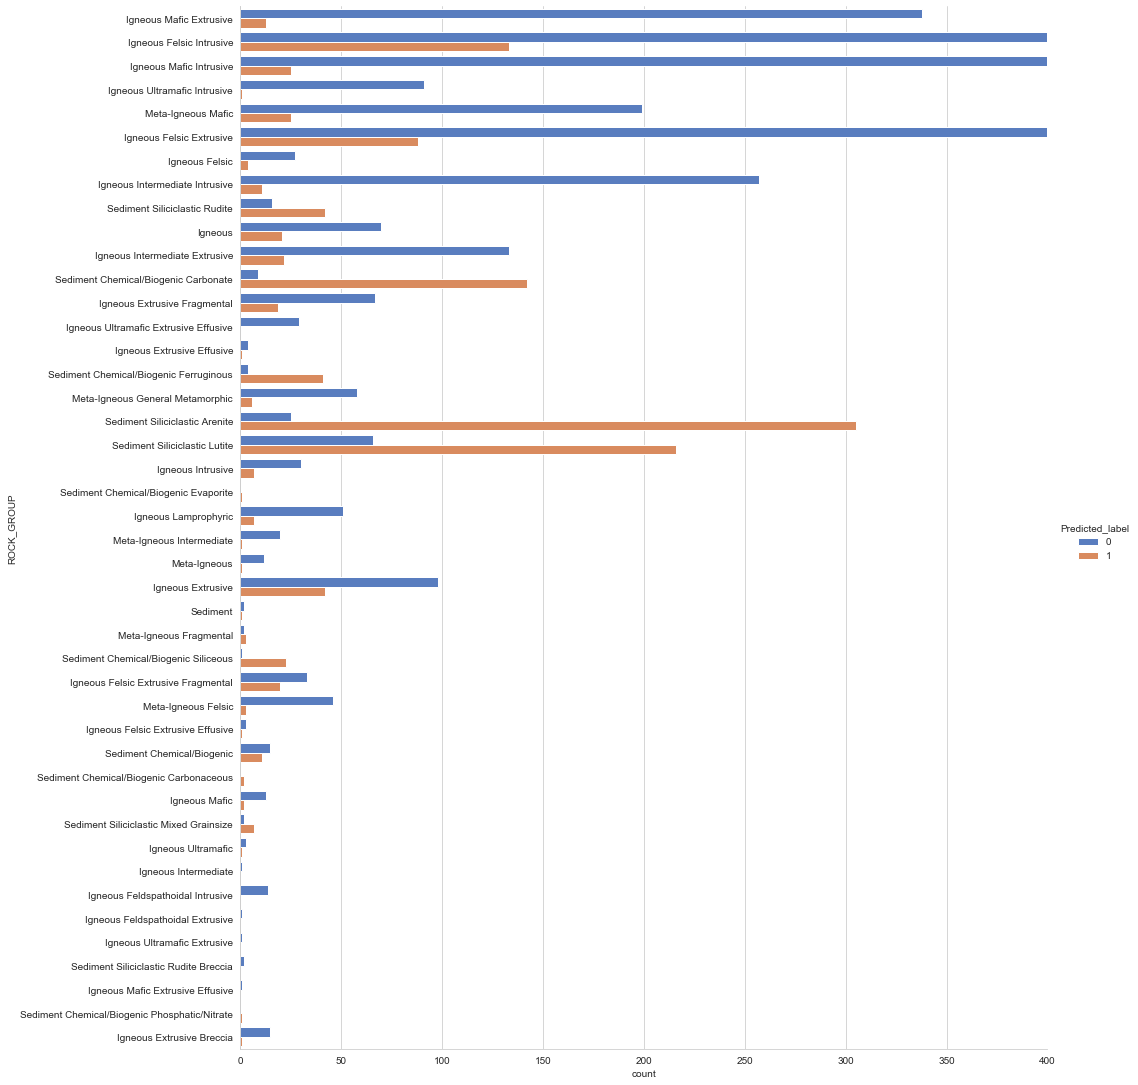

In [16]:
sns.catplot(hue='Predicted_label',y= 'ROCK_GROUP', data=SARIG_labeled_predicted, height = 15,kind='count',palette='muted')
plt.xlim(0,400)


### Plot by lithology label with predicted values as either igneous (Predicted_label=0) or sedimentary (Predicted_label=1)

(0, 250)

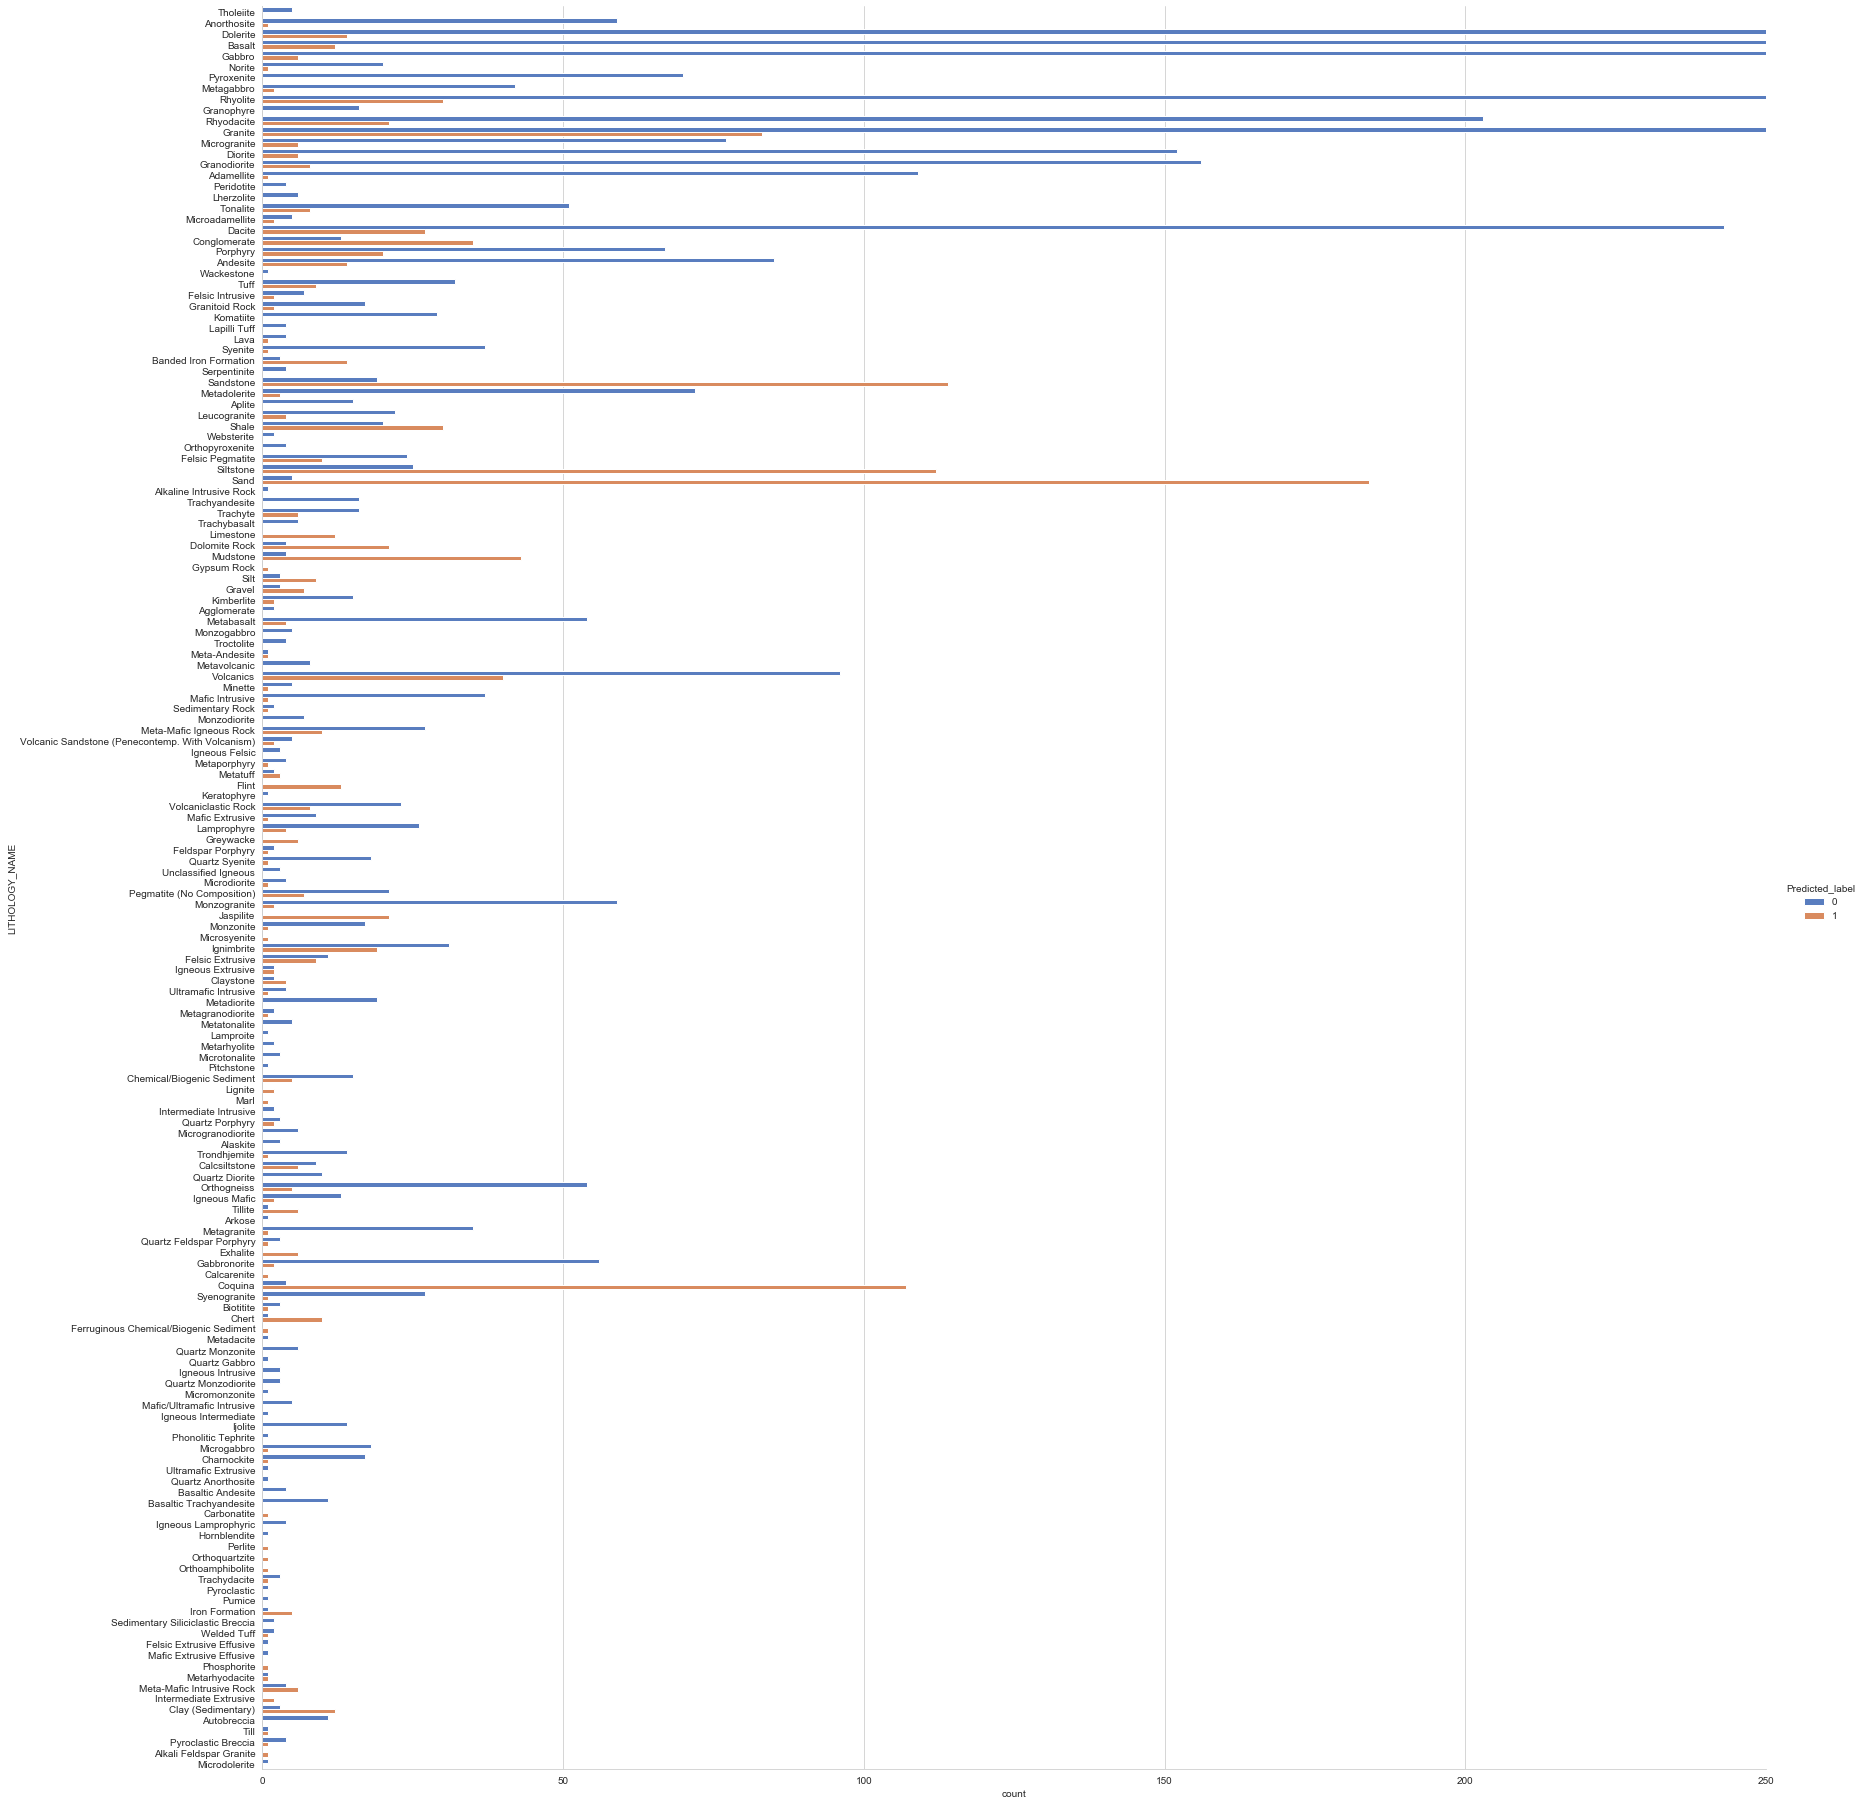

In [17]:
sns.catplot(hue='Predicted_label',y= 'LITHOLOGY_NAME', data=SARIG_labeled_predicted, height = 25,kind='count',palette='muted')
plt.xlim(0,250)

# 2. Load the Protolith App SARIG metamorphic output dataset

In [18]:
SARIG_met_predicted = pd.read_csv(r'D:\Python ML\SA-geology-lith-predictions\data\interim\SARIG_met_Lithology_predictions.csv')

In [19]:
SARIG_labeled_met = pd.merge(SARIG_met_predicted, df_met_labels, how= 'left', on='SAMPLE_ANALYSIS_NO')
SARIG_labeled_met['Predicted_label'] = np.where((SARIG_labeled_met.Class.str.contains('igneous')), 0, 1) 
SARIG_labeled_met.sample(20)

,SAMPLE_ANALYSIS_NO,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,P2O5,Class,Probability,Lithology,ROCK_GROUP,LITHOLOGY_NAME,labels,Predicted_label
3026,1618514,14.493228,0.113940,0.113940,84.982646,0.034182,0.148123,0.034182,0.011394,0.068364,sedimentary,0.716870,Quartzite,Mineralised Rock/Ore Metallic,Metallic Mineralised Rock/Ore,NaN,1
161,11134,57.826932,0.040652,0.731729,4.499177,22.764908,14.024810,0.081303,0.025407,0.005081,igneous,0.911560,"Andesite, Diorite",General/Miscellaneous,Mineral Specimen,NaN,0
1815,142240,65.013694,0.620399,16.714877,5.222544,1.374106,4.153083,3.117376,3.640357,0.143563,igneous,0.991041,"Dacite, Granodiorite",Metamorphic General,Gneiss,NaN,0
80,9915,70.380999,0.509139,13.776706,4.311790,0.928430,2.415915,2.875139,4.672100,0.129781,igneous,0.991158,"Rhyolite, Granite",Metamorphic General,Gneiss,NaN,0
3589,2105088,70.657636,1.051174,16.860417,4.729277,1.550742,0.530791,0.114484,4.454481,0.050998,sedimentary,0.767866,Wacke,Metamorphic General,Gneiss,NaN,1
662,37487,66.137258,0.710128,17.021865,8.764501,3.921600,0.211978,0.328567,2.893505,0.010599,sedimentary,0.680890,Shale,Metamorphic General,Gneiss,NaN,1
2125,890194,74.578764,0.460299,12.412554,3.332062,0.299970,0.724066,2.648012,5.482211,0.062063,igneous,0.995124,"Rhyolite, Granite",Metasediment,Quartzite,NaN,0
1562,125160,84.707249,0.192978,7.302699,1.215504,0.050784,0.030470,0.132038,6.337809,0.030470,sedimentary,0.631383,Subarkose,Breccia (Undifferentiated),Breccia (Undiff. Origin),NaN,1
2709,1583179,60.941346,0.722665,16.879400,6.641947,4.077898,2.147349,4.914125,3.448147,0.227123,sedimentary,0.558342,Shale,Metasediment,Metasediment,NaN,1
2636,1540899,57.070526,0.298045,11.911532,20.946068,1.510781,1.109962,2.857123,4.172633,0.123329,igneous,0.629652,"Trachyandesite, Monzonite",Metasediment,Metasediment,NaN,0


(0, 400)

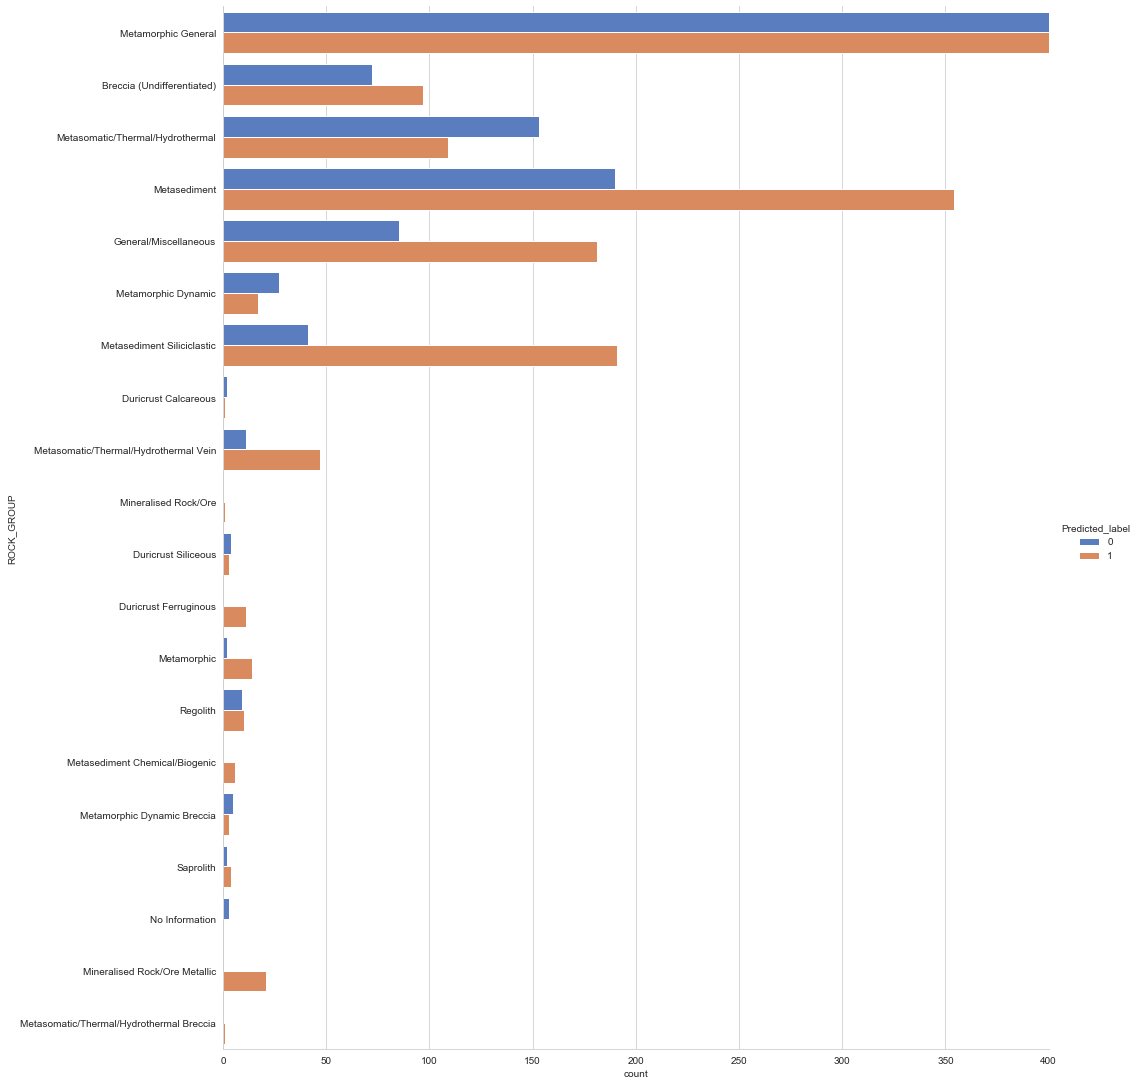

In [20]:
sns.catplot(hue='Predicted_label',y= 'ROCK_GROUP', data=SARIG_labeled_met, height = 15,kind='count',palette='muted')
plt.xlim(0,400)

(0, 250)

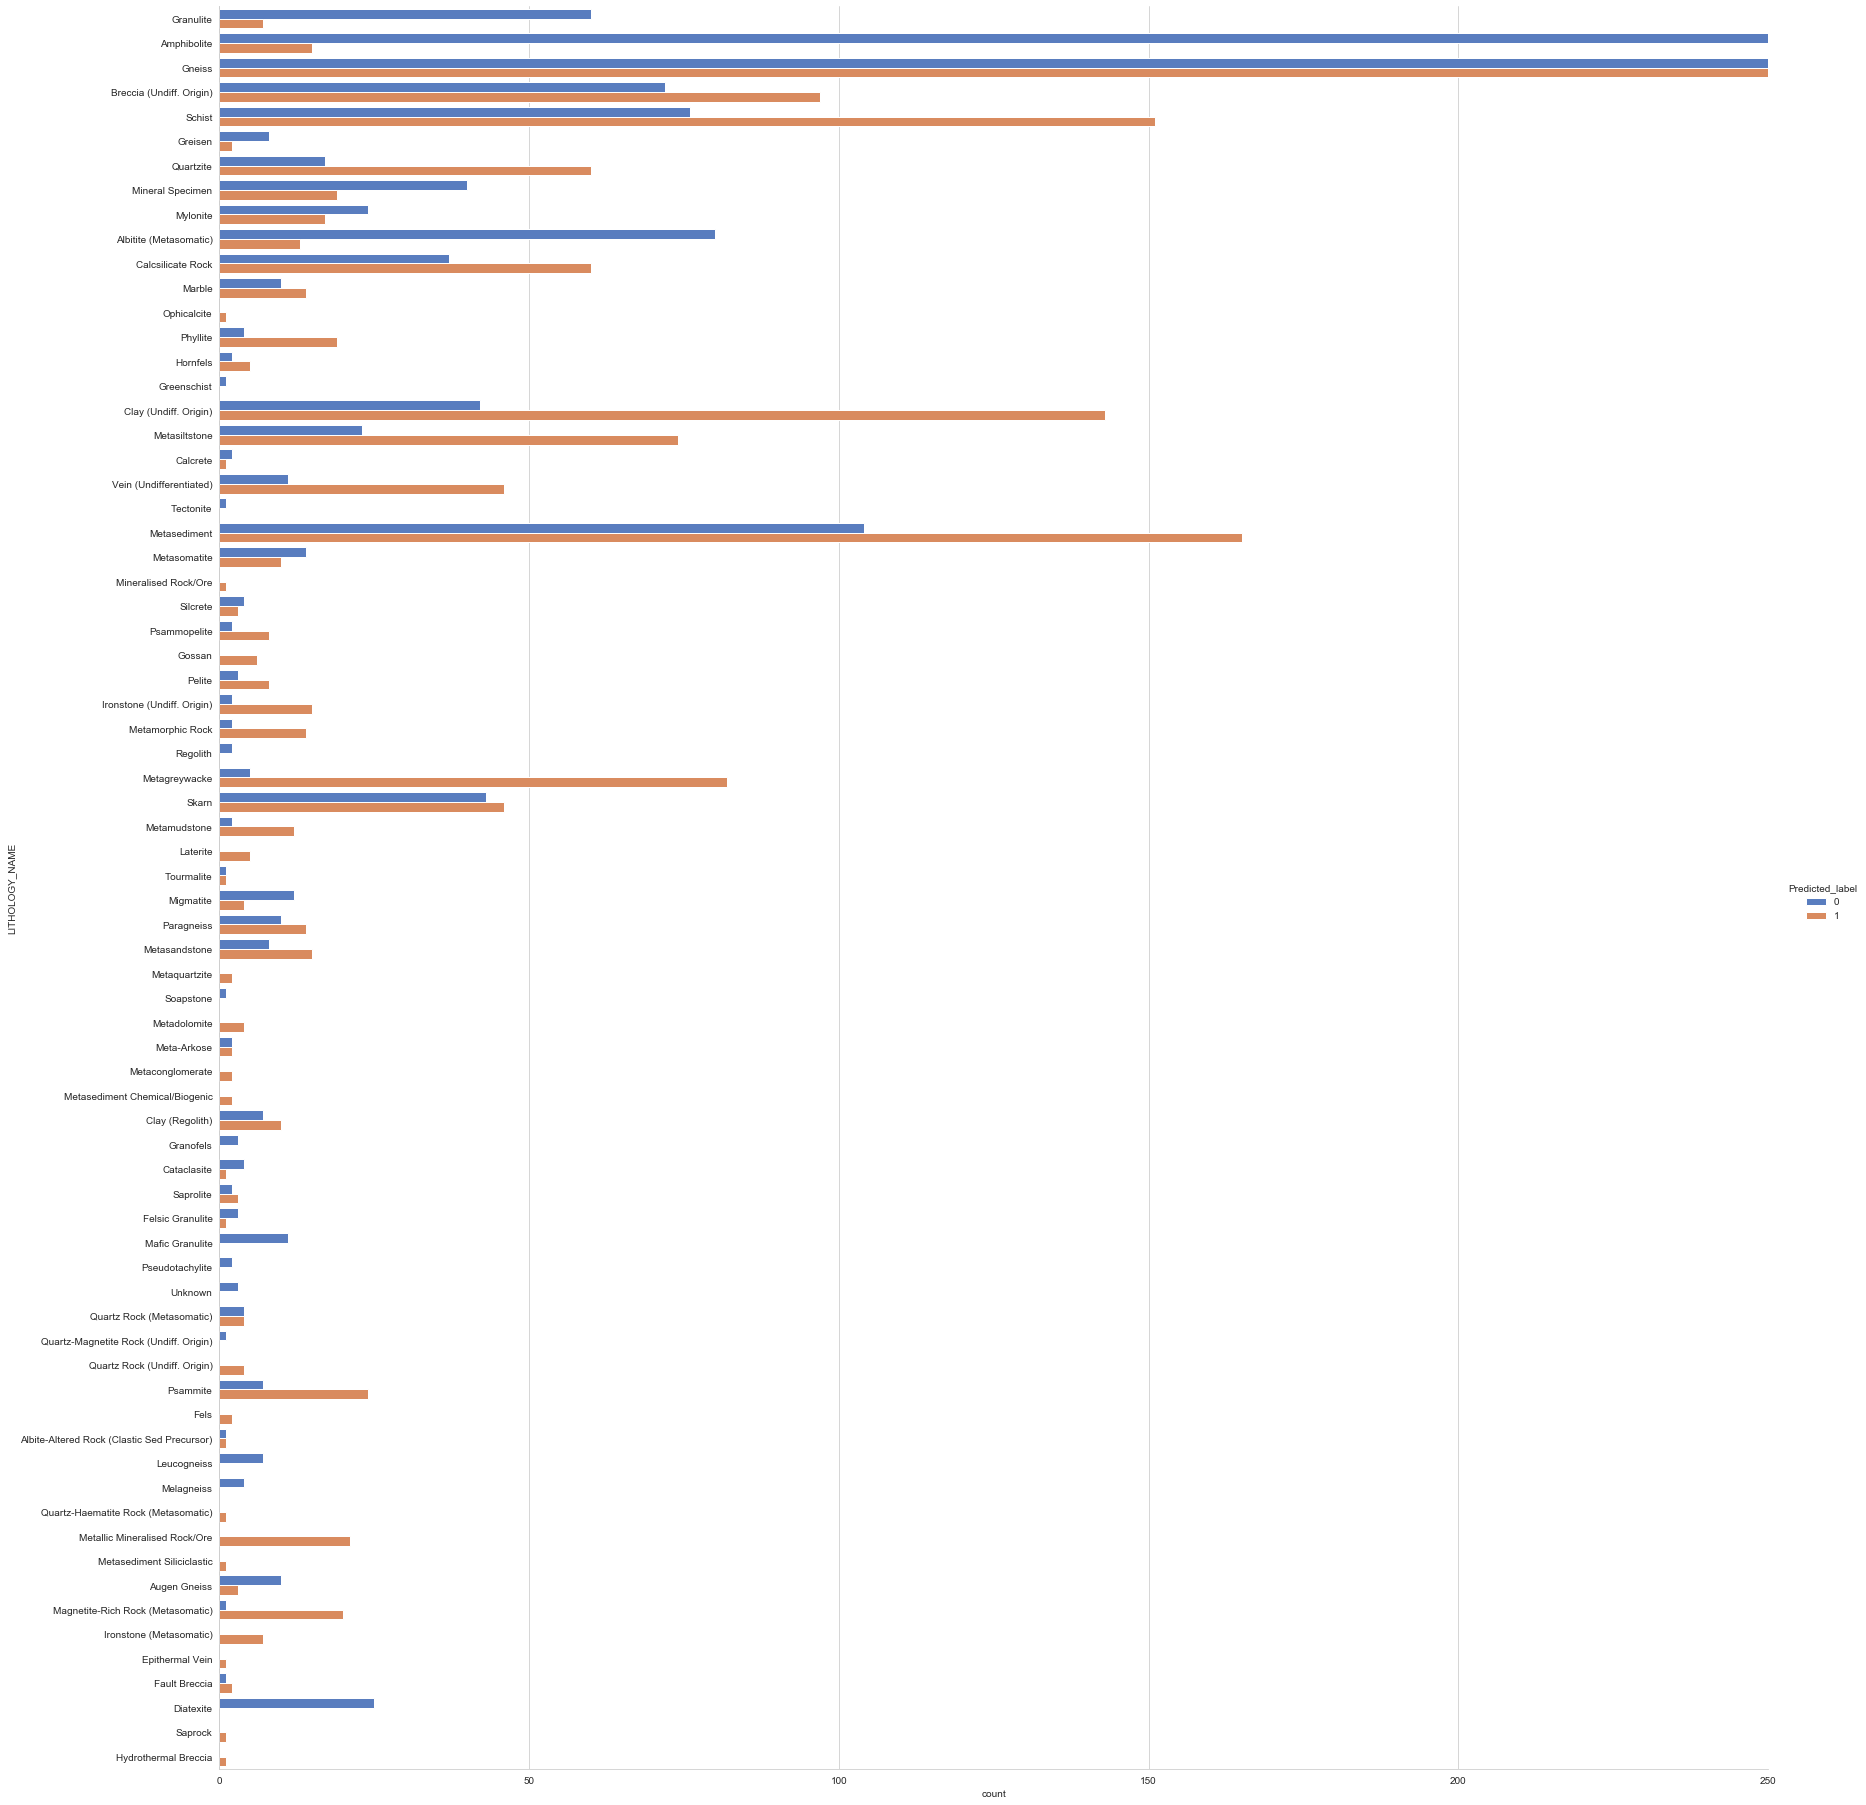

In [21]:
sns.catplot(hue='Predicted_label',y= 'LITHOLOGY_NAME', data=SARIG_labeled_met, height = 25,kind='count',palette='muted')
plt.xlim(0,250)

# 3. Load the Protolith App SARIG unlabeled output dataset

In [22]:
SARIG_unlabeled_predicted = pd.read_csv(r'D:\Python ML\SA-geology-lith-predictions\data\interim\SARIG_unlabeled_Lithology_predictions.csv')

In [23]:
SARIG_unlabeled_predicted.head()

,SAMPLE_ANALYSIS_NO,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,P2O5,Class,Probability,Lithology
0,8237,82.935383,0.249707,7.024374,0.752219,1.053113,6.872378,0.141139,0.966259,0.005428,sedimentary,0.501811,Arkose
1,10432,86.644054,0.070459,7.720259,0.311023,0.120786,0.120786,1.912450,3.080051,0.020131,sedimentary,0.721462,Subarkose
2,11061,3.739007,0.036838,0.976194,1.514934,37.574254,55.624631,0.036838,0.073675,0.423631,sedimentary,0.775708,Dolomite
3,53902,50.848240,0.153091,2.843127,7.232033,31.602455,6.834441,0.415534,0.065611,0.005468,igneous,0.996191,"Basalt, Gabbro"
4,53903,44.795192,0.138900,2.222397,9.790354,42.132946,0.578749,0.277800,0.057875,0.005787,igneous,0.995886,"Picrite, Peridotitgabbro"


In [24]:
SARIG_unlabeled_predicted['Lithology'].unique()

array(['Arkose', 'Subarkose', 'Dolomite', 'Basalt, Gabbro',
       'Picrite, Peridotitgabbro', 'Iron-rich Shale', 'Iron-rich Sand',
       'Quartz Arenite', 'Quartzite', 'Shale', 'unclassified',
       'Dacite, Granodiorite', 'Trachydacite, Quartz-syenite',
       'Litharnite', 'Basaltic Trachyandesite, Monzodiorite', 'Wacke',
       'Basaltic Andesite, Gabbroic Diorite', 'Andesite, Diorite',
       'Rhyolite, Granite', 'Limestone', 'Trachyte, Syenite',
       'Sublitharenite', 'Tephrite, Foid Gabbro', 'Peridotite',
       'Trachybasalt, Monzogabbro', 'Ultramafic Foidite',
       'Trachyandesite, Monzonite', 'Silexite', 'Phonolite, Foid Syenite',
       'Tephriphonolite, Foid Monzosyenite',
       'Phonotephrite, Foid Monzodiorite', 'Intermediate Foidite',
       'Mafic Foidite'], dtype=object)

## Below are plots of the predicted class (sedimentary = left and igneous = right) with a total count of each predicted lithology type.  

The first plot is a truncated y scale to show the smaller values better. Normal scale below.

It's clear from this that there are a lot of samples labeled Iron rich sand and Iron rich shale which may represent iron formation samples, or other altered or highly metamorphosed samples.



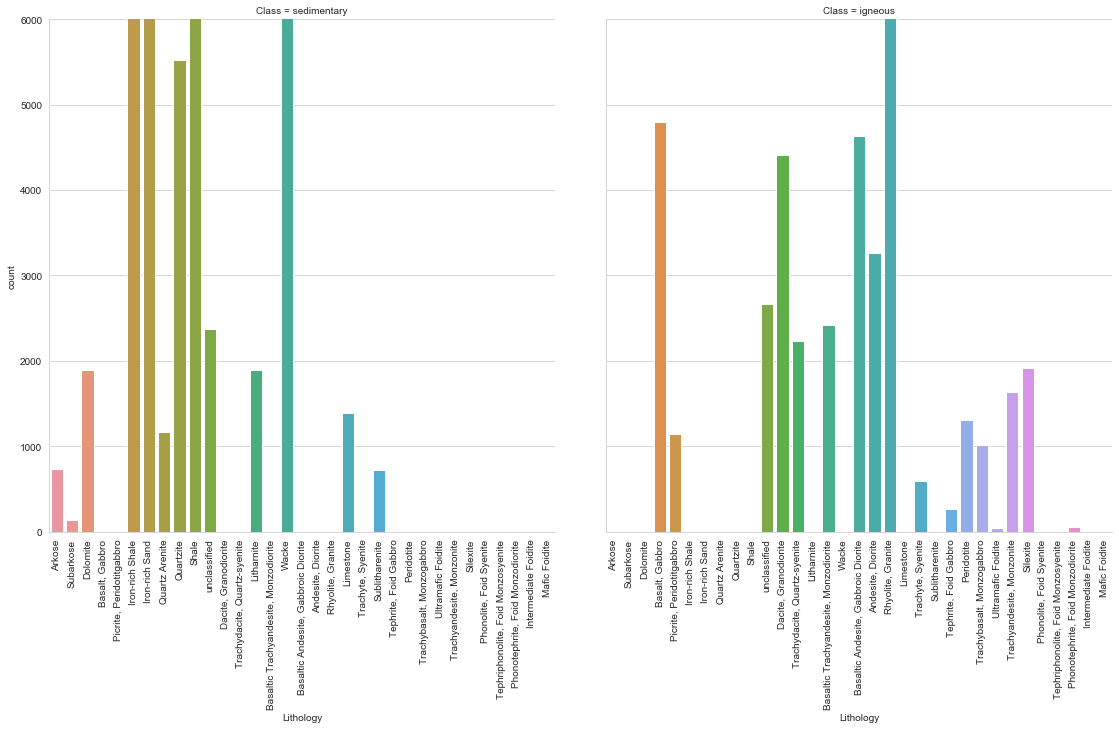

In [25]:
g=sns.catplot(x= 'Lithology',col='Class', data=SARIG_unlabeled_predicted, kind='count', height=8)
g.set_xticklabels(rotation=90)
g.set(ylim=(0,6000))
plt.show()

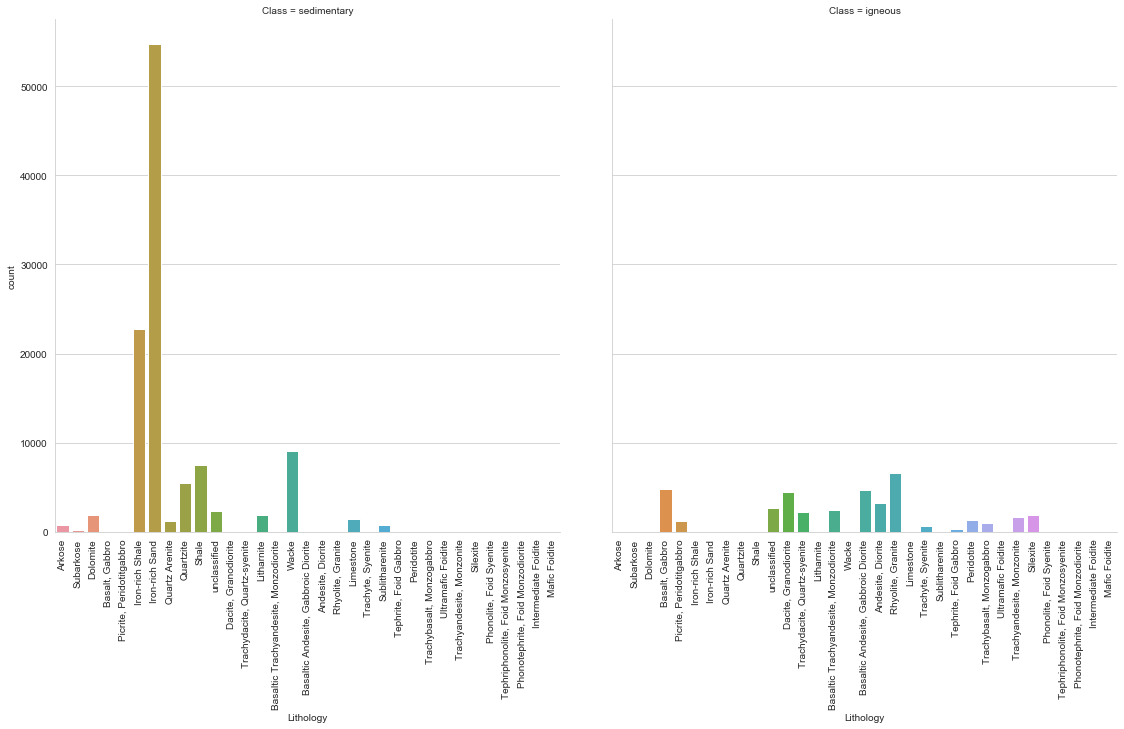

In [26]:

g=sns.catplot(x= 'Lithology',col='Class', data=SARIG_unlabeled_predicted, kind='count',height=8)
g.set_xticklabels(rotation=90)

## Output labeled predicted datasets with SA Geodata lithology code mappings

Create a mapping between the classified lithologies and the SA Geodata equivielnt codes, then map to a new GSSA_code column

In [27]:
GSSA_litho_map = {'Peridotite': "PRDT",
 'Ultramafic Foidite': "FDLT",
 'Mafic Foidite': "FDLT",
 'Intermediate Foidite': "FDLT",
 'Silexite': "QZOL",
 'Tephrite, Foid Gabbro': "FDGB",
 'Phonotephrite, Foid Monzodiorite': "FDMD",
 'Tephriphonolite, Foid Monzosyenite': "FDMS",
 'Trachybasalt, Monzogabbro': "MZGB",
 'Basaltic Trachyandesite, Monzodiorite': "MZDI",
 'Trachyandesite, Monzonite': "MONZ",
 'Phonolite, Foid Syenite': "FBSY",
 'Trachyte, Syenite': "SYEN",
 'Trachydacite, Quartz-syenite': "QZSY",
 'Picrite, Peridotitgabbro': "PICR" ,
 'Basalt, Gabbro': "GBRO",
 'Basaltic Andesite, Gabbroic Diorite': "BAAN",
 'Andesite, Diorite': "DIOR",
 'Dacite, Granodiorite': "GRDI",
 'Rhyolite, Granite': "GRNT",
 'Komatiite': "KOMT",
 'Picrite': "PICR",
 'Alkali picrite': "PICR",
 'Boninite': "BONN",
 'Shale': "SHLE",
 'Iron-rich Shale': "IRFM" ,
 'Iron-rich Sand': "IRFM",
 'Wacke': "GYWK",
 'Litharnite': "SDST",
 'Sublitharenite': "SDST",
 'Arkose': "ARKS",
 'Subarkose': "ARKS",
 'Quartz Arenite': "SDST",
 'Quartzite': "OQZT", 
 'Dolomite': "DLOM", 
 'Limestone': "LMST",
 'unclassified': "UNKN" }


In [28]:
SARIG_unlabeled_predicted['GSSA_code'] = SARIG_unlabeled_predicted['Lithology'].map(GSSA_litho_map)

In [29]:
SARIG_unlabeled_predicted.head(10)

,SAMPLE_ANALYSIS_NO,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,P2O5,Class,Probability,Lithology,GSSA_code
0,8237,82.935383,0.249707,7.024374,0.752219,1.053113,6.872378,0.141139,0.966259,0.005428,sedimentary,0.501811,Arkose,ARKS
1,10432,86.644054,0.070459,7.720259,0.311023,0.120786,0.120786,1.912450,3.080051,0.020131,sedimentary,0.721462,Subarkose,ARKS
2,11061,3.739007,0.036838,0.976194,1.514934,37.574254,55.624631,0.036838,0.073675,0.423631,sedimentary,0.775708,Dolomite,DLOM
3,53902,50.848240,0.153091,2.843127,7.232033,31.602455,6.834441,0.415534,0.065611,0.005468,igneous,0.996191,"Basalt, Gabbro",GBRO
4,53903,44.795192,0.138900,2.222397,9.790354,42.132946,0.578749,0.277800,0.057875,0.005787,igneous,0.995886,"Picrite, Peridotitgabbro",PICR
5,53904,49.001399,0.388234,6.767859,7.883665,27.281293,7.712212,0.881396,0.062957,0.020986,igneous,0.996159,"Basalt, Gabbro",GBRO
6,53905,49.030834,0.396420,6.937341,9.574623,25.558626,7.302465,1.053641,0.114753,0.031296,igneous,0.996365,"Basalt, Gabbro",GBRO
7,53906,44.178293,0.328057,5.423870,12.201110,33.352424,3.980420,0.448344,0.043741,0.043741,igneous,0.996679,"Picrite, Peridotitgabbro",PICR
8,53907,49.276925,0.389583,7.159895,7.626824,26.744314,7.844297,0.873928,0.063176,0.021059,igneous,0.995941,"Basalt, Gabbro",GBRO
9,53908,48.622944,0.387726,6.654218,8.863418,27.559988,7.020985,0.806889,0.062874,0.020958,igneous,0.996449,"Basalt, Gabbro",GBRO


In [30]:
SARIG_labeled_predicted['GSSA_code'] = SARIG_labeled_predicted['Lithology'].map(GSSA_litho_map)
SARIG_labeled_met['GSSA_code'] = SARIG_labeled_met['Lithology'].map(GSSA_litho_map)

In [31]:
SARIG_labeled_predicted.drop(['labels','Predicted_label'], axis=1).to_csv(r'D:\Python ML\SA-geology-lith-predictions\data\SARIG_predicted_lith_validated_data.csv',index=False)
SARIG_labeled_met.drop(['labels','Predicted_label'], axis=1).to_csv(r'D:\Python ML\SA-geology-lith-predictions\data\SARIG_predicted_lith_metamorphic_data.csv ',index=False)
SARIG_unlabeled_predicted.to_csv(r'D:\Python ML\SA-geology-lith-predictions\data\SARIG_predicted_lith_unlabeled_data.csv',index=False)